# Diffusion-based Conditional Facial Image Completion

In [12]:
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from typing import Dict, Tuple
from tqdm import tqdm
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F

from torchvision.datasets import MNIST
from torchvision import transforms, datasets
from torchvision.utils import save_image, make_grid
from pathlib import Path

import os
from PIL import Image

In [13]:
IMAGE_SIZE = (128, 112)

DATASET_ROOT = "./dataset"
IMAGES_DIR = "./images"
MODELS_DIR = "./"

USE_COLAB = False
if USE_COLAB:
    DATASET_ROOT = "/content/drive/MyDrive/deeplearning/group_project/dataset"
    MODELS_DIR = "/content/drive/MyDrive/deeplearning/group_project/models"
    from google.colab import drive
    drive.mount('/content/drive')

## Self Attention Block

In [14]:
# https://github.com/YigitEkin/Attention-Unet-Pytorch/blob/main/modules/modules.py
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.chanel_in = in_dim

        self.query_conv = nn.Conv2d(in_channels = in_dim, out_channels = in_dim//4, kernel_size = 1)
        self.key_conv = nn.Conv2d(in_channels = in_dim, out_channels = in_dim//4, kernel_size = 1)
        self.value_conv = nn.Conv2d(in_channels = in_dim, out_channels = in_dim, kernel_size = 1)

        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        m_batchsize, C, width, height = x.size()
        proj_query = self.query_conv(x).view(m_batchsize, -1, width*height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(m_batchsize, -1, width*height)
        energy = torch.bmm(proj_query, proj_key)
        attention = torch.softmax(energy, dim = -1)
        proj_value = self.value_conv(x).view(m_batchsize, -1, width*height)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(m_batchsize, C, width, height)

        out = self.gamma*out + x
        return out#, attention


## Unet with 4 en/decoder steps, consisting of 2 Resnet blocks + 3 RAA blocks at bottleneck resolution

In [15]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.convs = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )

        self.skip_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding = 0)

    def forward(self, x):
        out = self.convs(x)
        residual = self.skip_conv(x)
        out = out + residual
        return F.leaky_relu(out)


class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Time embedding
        self.time_mlp = nn.Sequential(
            nn.Linear(1, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 512) # 512 is the number of dimensions in latent space
        )

        # Encoder
        self.enc1 = nn.Sequential( # 6 input channels for noise (3), left half clean image (3)
            ResNetBlock(6, 64),
            ResNetBlock(64, 64)
        )
        self.down1 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)

        self.enc2 = nn.Sequential(
            ResNetBlock(64, 128),
            ResNetBlock(128, 128)
        )
        self.down2 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1)

        self.enc3 = nn.Sequential(
            ResNetBlock(128, 256),
            ResNetBlock(256, 256)
        )
        self.down3 = nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1)

        self.enc4 = nn.Sequential(
            ResNetBlock(256, 512),
            ResNetBlock(512, 512)
        )
        self.down4 = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            ResNetBlock(512, 512),
            SelfAttention(512),
            ResNetBlock(512, 512),
            SelfAttention(512),
            ResNetBlock(512, 512),
            SelfAttention(512)
        )

        # Decoder
        self.up4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec4 = nn.Sequential(
            ResNetBlock(1024, 256),  # 1024 because of skip connection (512 + 512)  
            ResNetBlock(256, 256)
        )

        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec3 = nn.Sequential(
            ResNetBlock(512, 128),  # 512 because of skip connection (256 + 256)  
            ResNetBlock(128, 128)
        )

        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec2 = nn.Sequential(
            ResNetBlock(256, 64),  # 256 because of skip connection (128 + 128)
            ResNetBlock(64, 64)
        )

        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec1 = nn.Sequential(
            ResNetBlock(128, 32),   # 128 because of skip connection (64 + 64)
            ResNetBlock(32, 32)
        )

        # Final convolution
        self.final_conv = nn.Conv2d(32, 3, kernel_size=1)

    def forward(self, x, t, verbose=False):
        # with torch.amp.autocast('cuda', dtype=torch.float32):
        # Create time embeddings
        t_emb = self.time_mlp(t.view(-1, 1))
        t_emb = t_emb.unsqueeze(-1).unsqueeze(-1)  # Shape: (batch_size, embedding_dim, 1, 1)
        latent_height = int((IMAGE_SIZE[0]/2) / 2**4)
        latent_width = int(IMAGE_SIZE[1] / 2**4)
        t_emb = t_emb.expand(-1, -1, latent_height, latent_width)  # Shape: (batch_size, embedding_dim, latent_height, latent_width)

        # Encoder path
        enc1 = self.enc1(x)
        down1 = self.down1(enc1)
        down1 = F.leaky_relu(down1)
        enc2 = self.enc2(down1)
        down2 = self.down2(enc2)
        down2 = F.leaky_relu(down2)
        enc3 = self.enc3(down2)
        down3 = self.down3(enc3)
        down3 = F.leaky_relu(down3)
        enc4 = self.enc4(down3)
        down4 = self.down4(enc4)
        down4 = F.leaky_relu(down4)

        # Bottleneck
        bottleneck = self.bottleneck(down4)
        bottleneck = bottleneck + t_emb # add time embedding in latent space

        # Decoder path
        up4 = self.up4(bottleneck)
        dec4 = self.dec4(torch.cat([up4, enc4], dim=1))
        up3 = self.up3(dec4)
        dec3 = self.dec3(torch.cat([up3, enc3], dim=1))
        up2 = self.up2(dec3)
        dec2 = self.dec2(torch.cat([up2, enc2], dim=1))
        up1 = self.up1(dec2)
        dec1 = self.dec1(torch.cat([up1, enc1], dim=1))

        output = self.final_conv(dec1)

        if verbose:
            return output, [x, enc1, down1, enc2, down2, enc3, down3, enc4, down4, bottleneck,
                            up4, dec4, up3, dec3, up2, dec2, up1, dec1, output]

        return output

## Unet Initialization

In [16]:
unet = UNet()
outputs, intermediates = unet(x= torch.zeros(1, 6, int(IMAGE_SIZE[0]/2), IMAGE_SIZE[1]),
                              t=torch.tensor([0.5]),
                              verbose=True)
for i in intermediates:
    print(i.shape)

torch.Size([1, 6, 64, 112])
torch.Size([1, 64, 64, 112])
torch.Size([1, 64, 32, 56])
torch.Size([1, 128, 32, 56])
torch.Size([1, 128, 16, 28])
torch.Size([1, 256, 16, 28])
torch.Size([1, 256, 8, 14])
torch.Size([1, 512, 8, 14])
torch.Size([1, 512, 4, 7])
torch.Size([1, 512, 4, 7])
torch.Size([1, 512, 8, 14])
torch.Size([1, 256, 8, 14])
torch.Size([1, 256, 16, 28])
torch.Size([1, 128, 16, 28])
torch.Size([1, 128, 32, 56])
torch.Size([1, 64, 32, 56])
torch.Size([1, 64, 64, 112])
torch.Size([1, 32, 64, 112])
torch.Size([1, 3, 64, 112])


## DDPM Schedule

In [17]:
"""
Minimal DDPM implementation (https://arxiv.org/abs/2006.11239), heavily inspired by https://github.com/cloneofsimo/minDiffusion.
"""

def ddpm_schedules(beta_1: float, beta_T: float, T: int) -> Dict[str, torch.Tensor]:
    """
    Returns pre-computed schedules for DDPM sampling, training process.
    """
    assert beta_1 < beta_T < 1.0, "beta1 and beta2 must be in (0, 1)"

    beta_t = torch.linspace(beta_1, beta_T, T + 1)
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab

    return {
        "alpha_t": alpha_t,  # \alpha_t
        "oneover_sqrta": oneover_sqrta,  # 1/\sqrt{\alpha_t}
        "sqrt_beta_t": sqrt_beta_t,  # \sqrt{\beta_t}
        "alphabar_t": alphabar_t,  # \bar{\alpha_t}
        "sqrtab": sqrtab,  # \sqrt{\bar{\alpha_t}}
        "sqrtmab": sqrtmab,  # \sqrt{1-\bar{\alpha_t}}
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,  # (1-\alpha_t) / \sqrt{1-\bar{\alpha_t}}
    }

## Conditional DDPM

In [18]:
class DDPM(nn.Module):
    def __init__(self, eps_model: nn.Module, beta_1: float, beta_T: float, T: int):
        super(DDPM, self).__init__()
        self.eps_model = eps_model
        self.T = T

        # `register_buffer` allows us to access these tensors by name.
        # Also, this places everything on the correct device.
        for k, v in ddpm_schedules(beta_1, beta_T, T).items():
            self.register_buffer(k, v)


    def forward(self, image_batch: torch.Tensor) -> torch.Tensor:
        """
        Makes forward diffusion x_t, and tries to guess epsilon value from x_t using eps_model.
        This implements Algorithm 1 in the paper https://arxiv.org/abs/2006.11239.
        """
        top_half_clean = image_batch[:, :, 0:int(IMAGE_SIZE[0]/2), :]
        bottom_half_clean = image_batch[:, :, int(IMAGE_SIZE[0]/2):IMAGE_SIZE[0], :]

        t = torch.randint(0, self.T + 1, (top_half_clean.shape[0],)).to(top_half_clean.device)  # t ~ Uniform({0, ..., T})
        eps = torch.randn_like(top_half_clean)  # eps ~ N(0, I)
        sqrt_alpha_bar = self.sqrtab[t, None, None, None]
        sqrt_one_minus_alpha_bar = self.sqrtmab[t, None, None, None]

        # Compute x_t
        bottom_half_noisy = sqrt_alpha_bar * bottom_half_clean + sqrt_one_minus_alpha_bar * eps
        loss = F.mse_loss(eps, self.eps_model(x=torch.cat([bottom_half_noisy, top_half_clean], dim=1), t=t/self.T)) # Monte-Carlo estimate of L_simple
        del t, eps, bottom_half_noisy, top_half_clean, bottom_half_clean
        torch.cuda.empty_cache()
        return loss

    # defining new ddpm schedule approach
    def sample(self, device, top_half_clean, step, new_noise_factor) -> torch.Tensor:
        # schedule = ddpm_schedules(beta_1=1e-4, beta_T=0.02, T=int(self.T/step))
        # adapting beta_T so that the cumulative noise is similar to the 1000 steps
        schedule = ddpm_schedules(beta_1=1e-4, beta_T=1e-4 + (0.02-1e-4)*step, T=int(self.T/step))
        # schedule = ddpm_schedules(beta_1=1e-4, beta_T=0.02*step, T=int(self.T/step))
        oneover_sqrta = schedule['oneover_sqrta']
        mab_over_sqrtmab = schedule['mab_over_sqrtmab']
        sqrt_beta_t = schedule['sqrt_beta_t']
        alphabar_t = schedule['alphabar_t']

        bottom_half_noisy_i = torch.randn(top_half_clean.shape).to(device)  # x_T ~ N(0, I)
        # This samples accordingly to Algorithm 2.
        for i in range(int(self.T/step), 0, -1):
            
            z = torch.randn(top_half_clean.shape).to(device) if i > 1 else 0
            t = torch.zeros((top_half_clean.shape[0], 1)).to(device).float() + (i / int(self.T/step))
            eps = self.eps_model(x=torch.cat([bottom_half_noisy_i, top_half_clean], dim=1), t=t)
            # using the parameters of the new schedule
            if new_noise_factor:
                # another approach for choosing sigma mentioned in the ddpm paper
                bottom_half_noisy_i = oneover_sqrta[i] * (bottom_half_noisy_i - eps * mab_over_sqrtmab[i]) + \
                  torch.sqrt((1-alphabar_t[i-1])/(1-alphabar_t[i])) * sqrt_beta_t[i] * z 
            else:
                # original approach to choose sigma²=beta_t
                bottom_half_noisy_i = oneover_sqrta[i] * (bottom_half_noisy_i - eps * mab_over_sqrtmab[i]) + \
                  sqrt_beta_t[i] * z

        inpainted_image = torch.cat((top_half_clean, bottom_half_noisy_i), dim=-2)
        # normalize to [0, 1]
        inpainted_image = (inpainted_image + 1.) / 2.
        # clip to [0, 1]
        inpainted_image = torch.clamp(inpainted_image, 0., 1.)
        return inpainted_image

def train_model(ddpm, dataloader, optim, device, num_epochs=5):
    losses = []
    lr_rates = []
    seen_images = 0
    save_model_counter = 0

    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optim, T_0=2*len(dataloader), T_mult=2)

    for i in range(num_epochs):
        print(f"Epoch {i+1} of {num_epochs}")
        ddpm.train()

        pbar = tqdm(dataloader)
        loss_ema = None
        scaler = torch.amp.GradScaler('cuda')

        for image_batch, _ in pbar:
            optim.zero_grad()
            image_batch = image_batch.to(device)
            # new for memory efficiency
            # with torch.amp.autocast('cuda'):
            loss = ddpm(image_batch)
            scaler.scale(loss).backward()
            scaler.step(optim)
            scaler.update()
            if loss_ema is None:
                loss_ema = loss.item()
            else:
                loss_ema = 0.9 * loss_ema + 0.1 * loss.item()
            pbar.set_description(f"loss: {loss_ema:.4f}")
            optim.step()
            lr_scheduler.step()
            # append batch loss
            losses.append(loss_ema)
            lr_rates.append(lr_scheduler.get_last_lr())
            seen_images += dataloader.batch_size
            #save model approx after every 50000 images it has trained on
            if(seen_images > (save_model_counter+1)*50000):
                torch.save({
                    'model_state_dict': ddpm.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'losses': losses,
                    'lrs': lr_rates,
                    'batch_size': dataloader.batch_size,
                    'dataset_size': len(dataloader.dataset),
                    'seen_images': seen_images
                    }, f"{MODELS_DIR}/model_epoch_{i+1}_batch_size_{dataloader.batch_size}_dataset_size_{len(dataloader.dataset)}_images_{seen_images}_loss_{losses[-1]}.pth")
                print(f"Model saved after training on {seen_images} images")
                save_model_counter+=1
            del image_batch
    torch.save({
        'model_state_dict': ddpm.state_dict(),
        'optimizer_state_dict': optim.state_dict(),
        'losses': losses,
        'lrs': lr_rates,
        'batch_size': dataloader.batch_size,
        'dataset_size': len(dataloader.dataset),
        'seen_images': seen_images
        }, f"{MODELS_DIR}/model_epoch_{i+1}_batch_size_{dataloader.batch_size}_dataset_size_{len(dataloader.dataset)}_images_{seen_images}_loss_{losses[-1]}.pth")
    print(f"Model saved after training on {seen_images} images")
    return ddpm

## Conditional DDPM Initialization

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

if device == 'cuda':
    torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 for faster matrix multiplications
    print(f"CUDA is available. Using device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA device count: {torch.cuda.device_count()}")
else:
    print("CUDA is not available. Using CPU.")

ddpm = DDPM(eps_model=UNet(), beta_1=1e-4, beta_T=0.02, T=1000)
# if torch.cuda.is_available():
ddpm = torch.compile(ddpm)
ddpm.to(device)

num_params = sum([x.numel() for x in ddpm.parameters() if x.requires_grad])
print(f"Number of parameters: {num_params/1e6:.2f}M")

CUDA is not available. Using CPU.
Number of parameters: 36.94M


## Dataset Loading

In [20]:
def load_dataset(split):
    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE[0], IMAGE_SIZE[1])),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    if split == "train":
        dataset = torch.utils.data.ConcatDataset([
            datasets.CelebA(
                root=DATASET_ROOT,
                split="train",
                download=DOWNLOAD_DATASET,
                transform=transform
            ),
            datasets.CelebA(
                root=DATASET_ROOT,
                split="valid",
                download=DOWNLOAD_DATASET,
                transform=transform
            )
        ])

    if split == "test":
        dataset = datasets.CelebA(
        root=DATASET_ROOT,
        split="test",
        download=DOWNLOAD_DATASET,
        transform=transform
        )
        
    return dataset

## Train or Load Model

/tmp/ipykernel_5846/4276973006.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f"{MODELS_DIR}/{CHECKPOINT_FILENAME}", map_location=device)


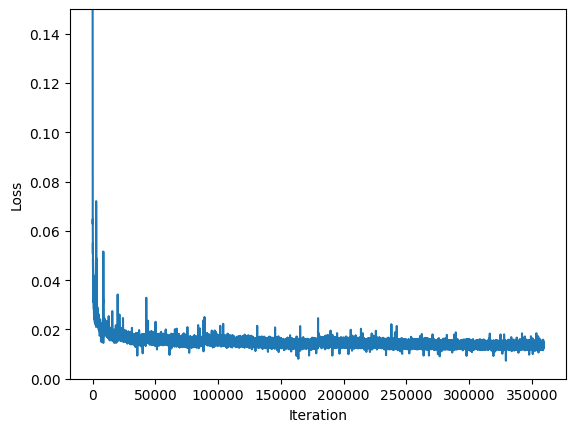

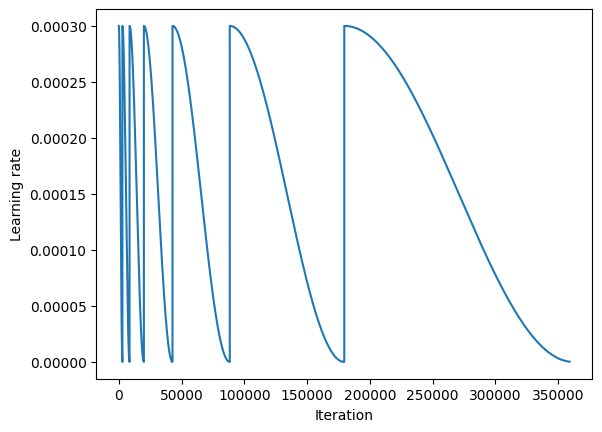

In [21]:
TRAIN_MODEL = False
DOWNLOAD_DATASET = False
CHECKPOINT_FILENAME = "model.pth"

if TRAIN_MODEL:
    dataset = load_dataset(split="train")
    dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)
    print(f"dataset size: {len(dataloader.dataset)}")
    print(next(iter(dataloader))[0].shape)
    optim = torch.optim.AdamW(ddpm.parameters(), lr=3e-4, weight_decay=1e-4)
    ddpm = train_model(ddpm, dataloader, optim, device, num_epochs=1)
else:
    model = torch.load(f"{MODELS_DIR}/{CHECKPOINT_FILENAME}", map_location=device)
    ddpm.load_state_dict(model['model_state_dict'])

    plt.plot(model['losses'])
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.ylim([0, 0.15])
    plt.show()

    plt.plot(model['lrs']) # this only works on newer models, where the LR has been saved
    plt.xlabel("Iteration")
    plt.ylabel("Learning rate")
    plt.show()

## Generating Images

In [ ]:
NUM_IMAGES = 6
NUM_SAMPLES = 3
USE_TEST_SET = False

torch.manual_seed(42)

if USE_TEST_SET:
  test_dataset = load_dataset(split="test")
  def load_top_half(index):
    image = test_dataset[index][0]
    # normalize to [0, 1]
    show_whole_image = (image + 1.) / 2.
    # clip to [0, 1]
    show_whole_image = torch.clamp(show_whole_image, 0., 1.).permute(1, 2, 0)
    return image[:, 0:int(IMAGE_SIZE[0]/2), :].to(device), show_whole_image
else: # manually load image file
  def load_top_half(index):
    transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
    path = f"{IMAGES_DIR}/{index+1:>06}.jpg"
    show_whole_image = transforms.Resize((IMAGE_SIZE[0], IMAGE_SIZE[1]))(Image.open(path))
    image = transform((show_whole_image.convert('RGB')))[:, 0:int(IMAGE_SIZE[0]/2), :].to(device)
    return image, show_whole_image


sampled_images = []
whole_images = []
for image_idx in range(NUM_IMAGES):
  top_half, whole_image = load_top_half(image_idx)
  whole_images.append(whole_image)
  for sample_idx in range(NUM_SAMPLES):
    ddpm.eval()
    with torch.no_grad():
      inpainted_image = ddpm.sample(device, top_half_clean=top_half[None, ...], step=1, new_noise_factor=True)[0].to('cpu').permute(1, 2, 0)
      sampled_images.append(inpainted_image)

# Plot grid of sampled images
fig, axs = plt.subplots(NUM_IMAGES, NUM_SAMPLES+1)
fig.set_size_inches(15, 15)
i = 0
for row in range(NUM_IMAGES):
  for col in range(NUM_SAMPLES+1):
    if col == 0:
      axs[row, col].imshow(whole_images[row])
    else:
      axs[row, col].imshow(sampled_images[i])
      i += 1
plt.show()
fig.savefig("./generated samples/samples.png")